In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os, shutil
from tqdm import tqdm
import pickle
import math

from keras.applications.resnet50 import ResNet50
from keras_applications.resnet import ResNet152
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten,Input, concatenate
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend, layers, models,utils
from keras.utils import multi_gpu_model
from keras_efficientnets.efficientnet import EfficientNetB3

import numpy as np
import pandas as pd
from collections import Counter
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4660421284147706649
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7044978669
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3284262274389609321
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


# 预处理

In [2]:
with open('ex_files.txt', 'rb') as ef:
    ex_files = pickle.load(ef)
len(ex_files['resnet50'])

130

In [3]:
data_dir = './{}/'
files = {x: os.listdir(data_dir.format(x)) for x in ['train', 'test']}
clean_data = [i for i in files['train'] if i not in ex_files['resnet50']]
len(clean_data)

24870

In [4]:
clean_labels = [x.split('.')[0] for x in clean_data]
df_smpl = pd.DataFrame({i: clean_labels.count(i) for i in set(clean_labels)}, index=[0])

C:\Users\lucifer\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  """Entry point for launching an IPython kernel.


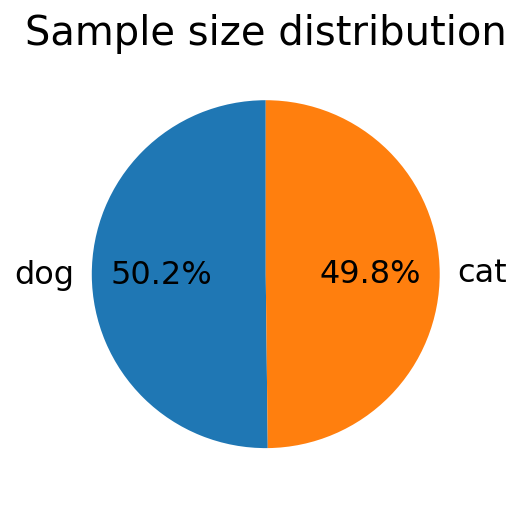

In [5]:
plt.pie(df_smpl, labels = df_smpl.columns, startangle=90, autopct = '%3.1f%%', textprops={'fontsize':16});
plt.title('Sample size distribution', fontsize = 20)
plt.savefig('sample_size_distribution_train.jpg')

In [6]:
data_dir = './train/'
nb_class = 2
with open('data_set.txt', 'rb') as ds:
    data_set = pickle.load(ds)

In [7]:
file_df = pd.DataFrame({'file_names': clean_data, 'labels': [x.split('.')[0] for x in clean_data]})
file_train, file_valid, label_train, label_valid = train_test_split(file_df['file_names'], file_df['labels'],
                                                                    test_size = 0.2, random_state = 0)
file_valid = file_valid.tolist()
file_train = file_train.tolist()
print(len(file_train), len(file_valid), len(label_train), len(label_valid))

19896 4974 19896 4974


In [8]:
data_set = {'file_train': file_train, 'label_train': label_train, 'file_valid': file_valid, 'label_valid': label_valid}
with open('data_set.txt', 'wb') as ds:
    pickle.dump(data_set, ds)

检查两个数据集有没有重叠

C:\Users\lucifer\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  after removing the cwd from sys.path.
C:\Users\lucifer\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':


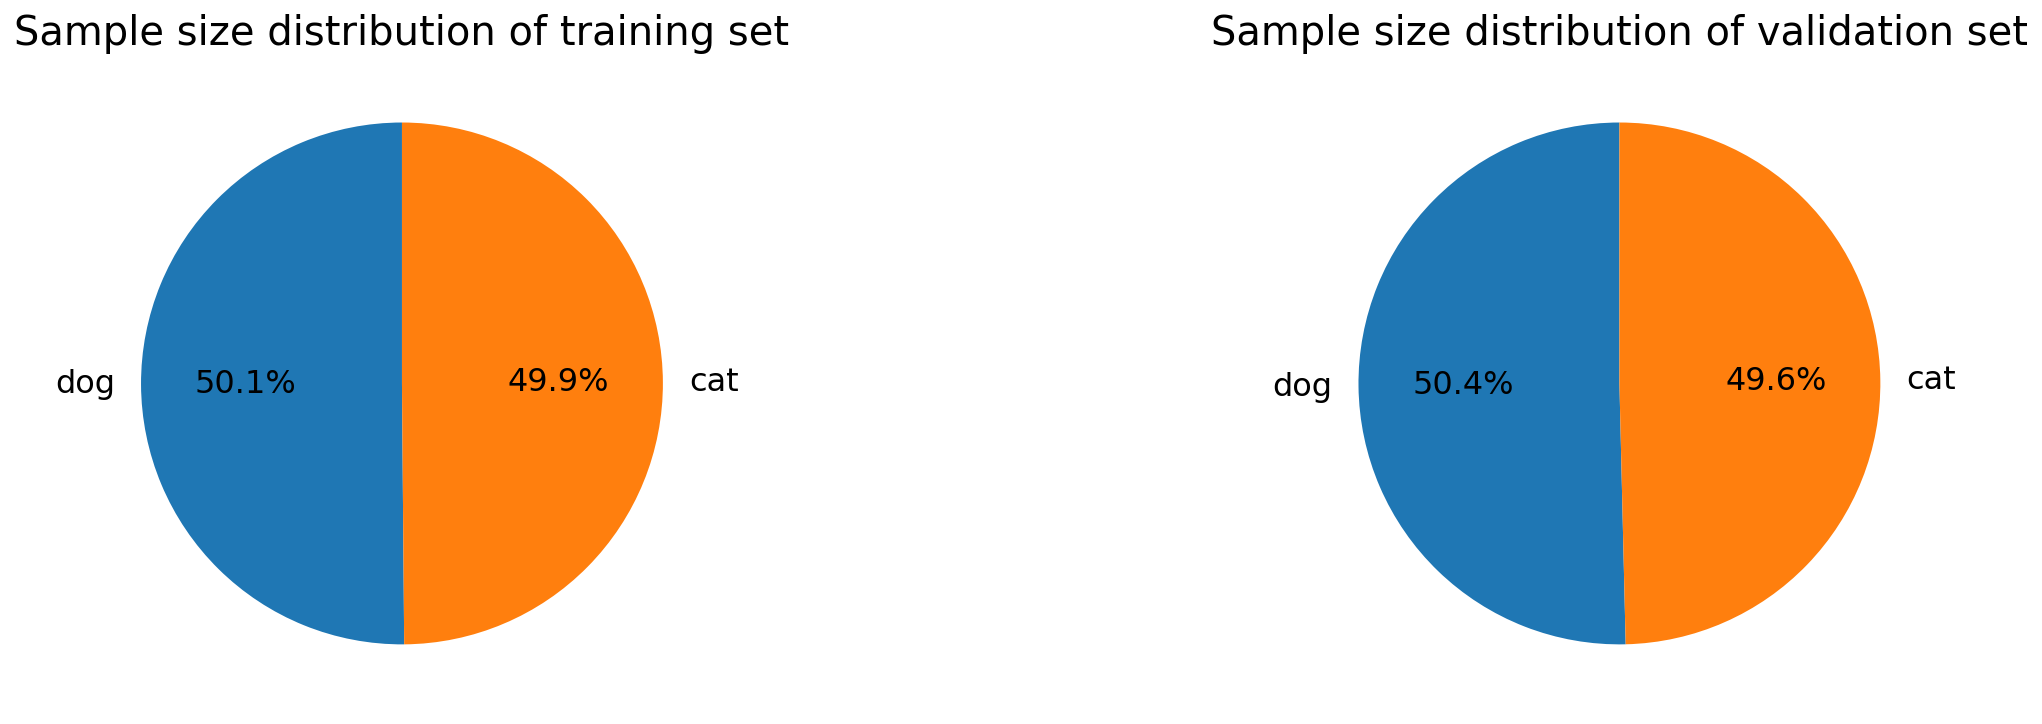

In [10]:
plt.figure(figsize=[20, 6])

plt.subplot(1, 2, 1)
train_dist = pd.DataFrame(Counter(label_train), index=[0])
ax, ltext, ptext = plt.pie(train_dist, labels = train_dist.columns, startangle=90, autopct = '%3.1f%%', textprops={'fontsize':16});
plt.title('Sample size distribution of training set', fontsize = 20)

plt.subplot(1, 2, 2)
valid_dist = pd.DataFrame(Counter(label_valid), index=[0])
plt.pie(valid_dist, labels = valid_dist.columns, startangle=90, autopct = '%3.1f%%', textprops={'fontsize':16})
plt.title('Sample size distribution of validation set', fontsize = 20);

plt.savefig('sample_size_distribution_train_valid.jpg', bbox_inches = 'tight')

In [10]:
# print(any([data['valid']['cat'][x] in data['train']['cat'] for x in range(len(data['valid']['cat']))]))
# print(any([data['valid']['dog'][x] in data['train']['dog'] for x in range(len(data['valid']['dog']))]))

## 图像变换

In [11]:
dataf = {x: pd.DataFrame({'X': data_set['file_{}'.format(x)],
                          'Y'.format(x): data_set['label_{}'.format(x)]}) for x in ['train', 'valid']}
dataf['train'].head()

,X,Y
24490,dog.9657.jpg,dog
16089,dog.2088.jpg,dog
19874,dog.5499.jpg,dog
11343,cat.9045.jpg,cat
6803,cat.4923.jpg,cat


```python
datagen = {'train': image.ImageDataGenerator(
   preprocessing_function=preprocess_input,
#     rotation_range=20
#     ,width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
    horizontal_flip=True
#     ,vertical_flip=True
),
           'valid':image.ImageDataGenerator(
   preprocessing_function=preprocess_input
)
          }
```

或者简单写法便于一个个增删：

In [12]:
datagen = {x: image.ImageDataGenerator(preprocessing_function=preprocess_input) for x in dataf.keys()}
datagen['train'].horizontal_flip = True
datagen['train'].rotation_range = 30
# datagen['train'].zoom_range = [0.2, 0.2]
datagen['train'].vertical_flip = True
# datagen['train'].zoom_range

In [13]:
im_width, im_height = 224, 224
batch_size = 128

generator = {x: datagen[x].flow_from_dataframe(
    dataf[x], x_col = 'X', y_col = 'Y',directory = data_dir.format('train'),
    target_size=(im_width, im_height),
    batch_size=batch_size,
    seed = 123,
    class_mode = 'binary'
) for x in datagen.keys()}

generator['valid'].shuffle = False

Found 19896 validated image filenames belonging to 2 classes.
Found 4974 validated image filenames belonging to 2 classes.


## 建立模型

选择三个模型：

In [14]:
model_dict = {'VGG19': VGG19, 'ResNet152': ResNet152, 'EfficientNetB3': EfficientNetB3, 'inception_v3': InceptionV3}

### 模型1

In [15]:
model_1_name = 'ResNet152'
model_base = ResNet152(weights = 'imagenet', include_top = False, input_shape = (im_width, im_height, 3),
                           backend = backend, layers = layers, models = models, utils = utils)
model_1 = Sequential()
model_1.add(model_base)
model_1.add(GlobalAveragePooling2D())
model_1.add(Dropout(0.75))
model_1.add(Dense(1, activation='sigmoid'))
out_1 = model_1.output

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
print('Number of trainable weights befor freezing the model_base:', len(model_1.trainable_weights))
# for layer in model.layers[:173]:
#     layer.trainable = False
model_base.trainable = False
print('Number of trainable weights after freezing the model_base:', len(model_1.trainable_weights))

Number of trainable weights befor freezing the model_base: 622
Number of trainable weights after freezing the model_base: 2


In [18]:
lr = 0.00005
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_1.compile(loss = "binary_crossentropy", optimizer = optimizers.Adam(lr=lr), metrics=["accuracy"])

In [19]:
epochs = 40
history_1 = model_1.fit_generator(generator['train'],
                                  steps_per_epoch=math.ceil(generator['train'].samples / batch_size),
                                  epochs=epochs,
                                  validation_data=generator['valid'],
                                  validation_steps=math.ceil(generator['valid'].samples / batch_size),
                                  callbacks=[early_stopping],
                                  verbose = 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
 - 178s - loss: 0.8875 - acc: 0.5805 - val_loss: 0.4540 - val_acc: 0.8183
Epoch 2/40
 - 168s - loss: 0.7200 - acc: 0.6625 - val_loss: 0.2959 - val_acc: 0.8985
Epoch 3/40
 - 165s - loss: 0.5867 - acc: 0.7296 - val_loss: 0.2148 - val_acc: 0.9314
Epoch 4/40
 - 168s - loss: 0.5113 - acc: 0.7708 - val_loss: 0.1748 - val_acc: 0.9419
Epoch 5/40
 - 170s - loss: 0.4472 - acc: 0.8016 - val_loss: 0.1419 - val_acc: 0.9550
Epoch 6/40
 - 172s - loss: 0.4113 - acc: 0.8220 - val_loss: 0.1236 - val_acc: 0.9612
Epoch 7/40
 - 174s - loss: 0.3752 - acc: 0.8416 - val_loss: 0.1120 - val_acc: 0.9634
Epoch 8/40
 - 173s - loss: 0.3530 - acc: 0.8492 - val_loss: 0.1046 - val_acc: 0.9640
Epoch 9/40
 - 172s - loss: 0.3378 - acc: 0.8541 - val_loss: 0.0976 - val_acc: 0.9668
Epoch 10/40
 - 173s - loss: 0.3174 - acc: 0.8662 - val_loss: 0.0922 - val_acc: 0.9682
Epoch 11/40
 - 173s - loss: 0.3027 - acc: 0.8764 - val_loss: 0.0836 - val_acc: 0.9717
Epoch 12/40
 - 

In [21]:
model_1.save('model_1.h5')

### 模型2

In [ ]:
# model_2_name = 'EfficientNetB3'
# model_base = model_dict[model_2_name](weights='imagenet', include_top=False, input_shape = (im_width, im_height, 3))
# model_2 = Sequential()
# model_2.add(model_base)
# model_2.add(GlobalAveragePooling2D())
# model_2.add(Dropout(0.9))
# model_2.add(Dense(1, activation='sigmoid'))
# out_2 = model_2.output

### 模型3

In [ ]:
# model_3_name = 'VGG19'
# model_base = model_dict[model_3_name](weights='imagenet', include_top=False, input_shape = (im_width, im_height, 3))
# model_3 = Sequential()
# model_3.add(model_base)
# model_3.add(GlobalAveragePooling2D())
# model_3.add(Dropout(0.5))
# model_3.add(Dense(500, activation = 'relu'))
# model_3.add(Dropout(0.5))
# model_3.add(Dense(1, activation='sigmoid'))
# out_3 = model_3.output

### 模型4

In [ ]:
# model_4_name = 'inception_v3'
# model_base = model_dict[model_4_name](weights='imagenet', include_top=False, input_shape = (im_width, im_height, 3))
# model_4 = Sequential()
# model_4.add(model_base)
# model_4.add(GlobalAveragePooling2D())
# model_4.add(Dropout(0.5))
# model_4.add(Dense(500, activation = 'relu'))
# model_4.add(Dropout(0.5))
# model_4.add(Dense(1, activation='sigmoid'))
# out_4 = model_4.output

In [ ]:
# if model_name == 'ResNet152':
#     model_base = ResNet152(weights = 'imagenet', include_top = False, input_shape = (im_width, im_height, 3),
#                            backend = backend, layers = layers, models = models, utils = utils)
# else:
#     model_base = model_dict[model_name](weights='imagenet', include_top=False, input_shape = (im_width, im_height, 3))

或者这种写法：
```python
x = model_base.output
# x = Flatten()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5,)(x)
# x = Dense(500, activation='relu')(x)
# x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=model_base.input, outputs=output)
```

### 融合模型

In [ ]:
merger = concatenate([out_1, out_2])
out = Dense(1, activation='sigmoid')(merger)
model = Model(Input(shape = (im_width, im_height, 3)), out)

查看冻结层前后的可训练层数：

In [ ]:
model = model_2
print('Number of trainable weights befor freezing the model_base:', len(model.trainable_weights))
# for layer in model.layers[:173]:
#     layer.trainable = False
model_base.trainable = False
print('Number of trainable weights after freezing the model_base:', len(model.trainable_weights))

In [ ]:
model.summary()

编译模型：

In [ ]:
lr = 0.00005
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss = "binary_crossentropy", optimizer = optimizers.Adam(lr=lr), metrics=["accuracy"])

## 训练模型

In [ ]:
epochs = 30
history = model.fit_generator(generator['train'],
                              steps_per_epoch=math.ceil(generator['train'].samples / batch_size),
                              epochs=epochs,
                              validation_data=generator['valid'],
                              validation_steps=math.ceil(generator['valid'].samples / batch_size),
                              callbacks=[early_stopping],
                              verbose = 2)

保存模型checkpoint：

In [20]:
model.save('model_binary.h5')

NameError: name 'model' is not defined

## 重新载入模型

In [ ]:
# model = load_model('model_binary.h5')

## 可视化

NameError: name 'model_name' is not defined

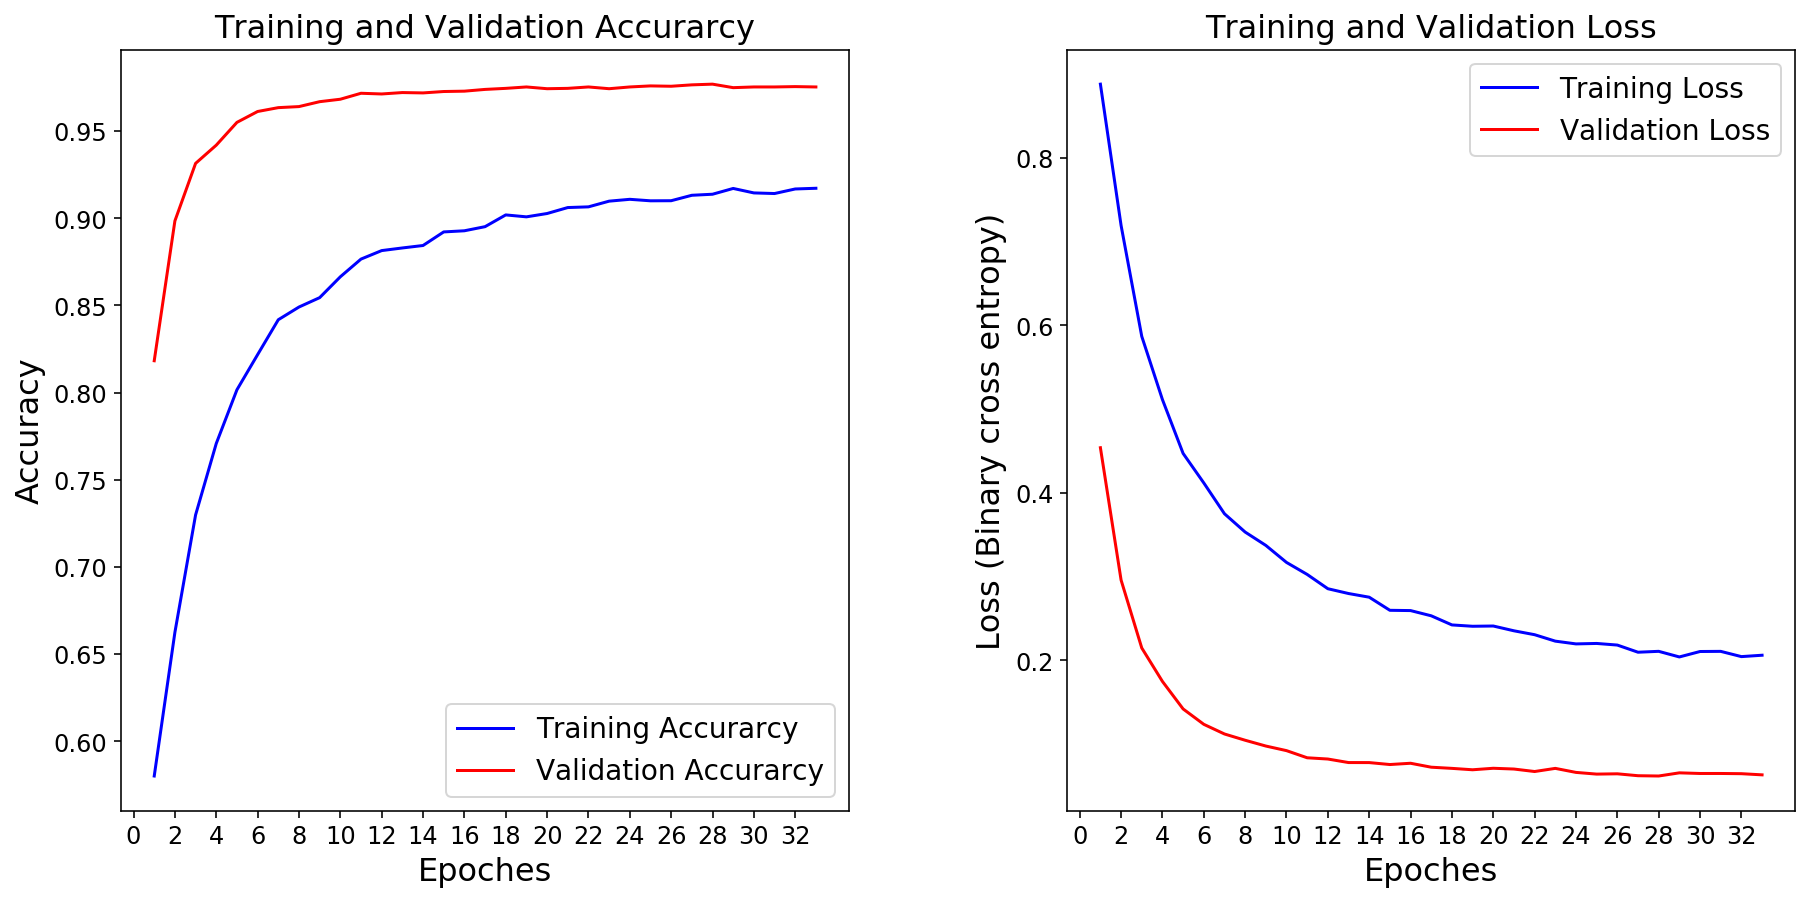

In [23]:
#get the details form the history object
history = history_1
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

x_axis = range(1, len(acc)+1)

#Train and validation accuracy

plt.figure(figsize = [15, 7])
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
plt.plot(x_axis, acc, 'blue', label='Training Accurarcy')
plt.plot(x_axis, val_acc, 'red', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy', fontsize = 16)
plt.xlabel('Epoches', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.legend(fontsize = 14)
plt.xticks(ticks=range(0, len(acc)+1, 2),fontsize = 12)
plt.yticks(fontsize = 12)


plt.subplot(1,2,2)
#Train and validation loss
plt.plot(x_axis, loss, 'blue', label='Training Loss')
plt.plot(x_axis, val_loss, 'red', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize = 16)
plt.xlabel('Epoches', fontsize = 16)
plt.ylabel('Loss (Binary cross entropy)', fontsize = 16)
plt.legend(fontsize = 14)
plt.xticks(ticks=range(0, len(acc)+1, 2), fontsize = 12)
plt.yticks(fontsize = 12)

# plt.suptitle('Pre-trained model: {}\nLearning rate: {}'.format(model_name, lr),
#             x = 0.1, y = 1, ha = 'left', fontsize = 14)
plt.savefig('{} loss and acc-lr {}.jpg'.format(model_name, lr), bbox_inches = 'tight')
plt.show()

# 预测

In [ ]:
test_imgs = os.listdir(data_dir.format('test'))
img_path = data_dir.format('test') + test_imgs[3]
# img_path = './test04.jpg'
img = image.load_img(img_path, target_size=(im_width, im_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)[0][0]
print(preds)
img_show = mpimg.imread(img_path)
plt.imshow(img_show)
plt.suptitle('This is a {}'.format('dog' if preds > 0.5 else 'cat'))
plt.title('probability: {}%'.format(round(preds*100, 2)) if preds > 0.5 else round((1-preds)*100, 2));

全部预测，制作csv表

In [25]:
model = model_1
test_imgs = os.listdir('test/')
ids = []
label = []
for i in tqdm(test_imgs):
    img = image.load_img('test/' + i, target_size=(im_width, im_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    label.append(model.predict(x)[0][0])
    ids.append(int(i.split('.')[0]))

100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [05:05<00:00, 40.86it/s]


In [26]:
sub = pd.DataFrame({'id': ids, 'label': label}).sort_values('id',axis = 0, ascending = True)
sub.to_csv('results/submission.csv', index = False)

# 参考资料

+ https://zhuanlan.zhihu.com/p/26693647
+ https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8
+ https://www.kaggle.com/risingdeveloper/transfer-learning-in-keras-on-dogs-vs-cats